# <font color = "red">Classificação de Risco de Crédito</font>

## PRÉ PROCESSAMENTO DOS DADOS E ENGENHARIA DE ATRIBUTOS 

<font color = "red">Problema de Negócio:</font> A partir de dados históricos, irei verificar os padrões que levaram os clientes de uma instituição financeira, a adentrarem, ou não, na situação de inadimplência, para posteriormente criar um 

<font color = "red">Meta de Acurácia Final:</font> ACC mínimo de 88%

<font color = "blue">Foco deste notebook será preparar os dados para a etapa de modelagem, aplicando codifica~ção às variáveis categóricas, escalonamento às numéricas e balanceamento de classe, se for necessário. Após, analisarei a importância das variáveis, juntamente com o relatório da análise exploratória, com intuito de remover variáveis irrelevantes e correlacionadas.

In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Regularização de classe
from imblearn.over_sampling import SMOTE


# Feature Importance
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando os dados 
df = pd.read_csv("C:/Projetos Pessoais/DataScience/analise_Risco_Credito/data/df_para_pre_processamento_4.csv")

<font color = "red">Codificação das Variáveis

In [3]:
# Objeto Encoder e Standard
lb = LabelEncoder()
scaler = StandardScaler()

In [4]:
df_processing = df.copy()

In [5]:
df.sample()

,Idade,Renda_Anual,Tipo_Moradia,Anos_no_Emprego,Motivo_Emprestimo,Grau_Emprestimo,Valor,Taxa_Juros,Status_Pagamento,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito
2381,25.0,37000.0,Hipoteca,6.0,Reformas Domésticas,D,7000.0,15.62,Adimplente,0.19,Sim,3.0


- Label Encoder para variáveis

In [6]:
# Encoder para Varíavel Target
df_processing['Status_Pagamento'] = lb.fit_transform(df_processing['Status_Pagamento'])
df_processing['Inadimplencia_Historica'] = lb.fit_transform(df_processing['Inadimplencia_Historica'])

# Encoder em Grau emprestimo, pois há hierarquia dentro da variável - A é melhor q B
df_processing['Grau_Emprestimo'] = lb.fit_transform(df_processing['Grau_Emprestimo'])
df_processing.sample()


,Idade,Renda_Anual,Tipo_Moradia,Anos_no_Emprego,Motivo_Emprestimo,Grau_Emprestimo,Valor,Taxa_Juros,Status_Pagamento,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito
3174,26.0,40272.0,Hipoteca,3.0,Educação,1,10000.0,11.86,0,0.25,0,3.0


- Get Dummies para variáveis sem hierárquias e não binárias

In [7]:
df_processing = pd.get_dummies(df_processing, columns=['Tipo_Moradia', 'Motivo_Emprestimo'], drop_first=True)

In [8]:
df_processing

,Idade,Renda_Anual,Anos_no_Emprego,Grau_Emprestimo,Valor,Taxa_Juros,Status_Pagamento,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito,Tipo_Moradia_Hipoteca,Tipo_Moradia_Outro,Tipo_Moradia_Próprio,Motivo_Emprestimo_Educação,Motivo_Emprestimo_Empreendimento,Motivo_Emprestimo_Médico,Motivo_Emprestimo_Pessoal,Motivo_Emprestimo_Reformas Domésticas
0,21.0,9600.0,5.0,1,1000.0,11.14,0,0.10,0,2.0,False,False,True,True,False,False,False,False
1,21.0,9900.0,2.0,0,2500.0,7.14,1,0.25,0,2.0,False,False,True,False,True,False,False,False
2,21.0,10000.0,6.0,3,1600.0,14.74,1,0.16,0,3.0,False,False,True,False,True,False,False,False
3,24.0,10800.0,8.0,1,1750.0,10.99,1,0.16,0,2.0,True,False,False,True,False,False,False,False
4,24.0,10980.0,0.0,0,1500.0,7.29,0,0.14,0,3.0,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21728,31.0,83000.0,9.0,5,18000.0,19.74,1,0.22,1,8.0,True,False,False,False,True,False,False,False
21729,29.0,61656.0,4.0,0,15000.0,6.91,0,0.24,0,9.0,False,False,False,False,False,False,True,False
21730,32.0,30000.0,1.0,1,11450.0,9.99,1,0.38,0,6.0,False,False,False,True,False,False,False,False
21731,31.0,26010.0,2.0,1,6500.0,9.99,0,0.25,0,9.0,True,False,False,False,False,False,True,False


In [9]:
# Os dados ficaram no formato True/False - transformar em 0 e 1
var_dummies = ['Tipo_Moradia_Hipoteca',	'Tipo_Moradia_Outro','Tipo_Moradia_Próprio',
               'Motivo_Emprestimo_Educação', 'Motivo_Emprestimo_Empreendimento', 'Motivo_Emprestimo_Médico',
            	'Motivo_Emprestimo_Pessoal', 'Motivo_Emprestimo_Reformas Domésticas']
for x in var_dummies:
    df_processing[x] = np.where(df_processing[x] == True, 1,0)

- Padonização dos Dados numéricos

In [10]:
var_padronizacao = ['Idade', 'Renda_Anual', 'Anos_no_Emprego', 'Valor', 'Taxa_Juros', 'Comprometimento_Renda', 'Duracao_Historico_Credito']

for var in var_padronizacao:
 df_processing[var] = scaler.fit_transform(df_processing[[var]])

<font color = "red">Regularizando Variável Target 

In [11]:
df_processing.Status_Pagamento.value_counts()

Status_Pagamento
0    17471
1     4262
Name: count, dtype: int64

Text(0.5, 1.0, 'Contagem das Classes\n')

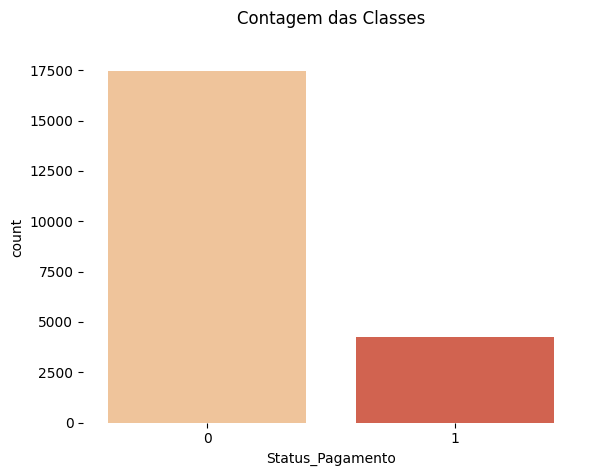

In [12]:
sns.countplot(x='Status_Pagamento', data=df_processing, palette= "OrRd")
plt.box(False)
plt.title("Contagem das Classes\n")

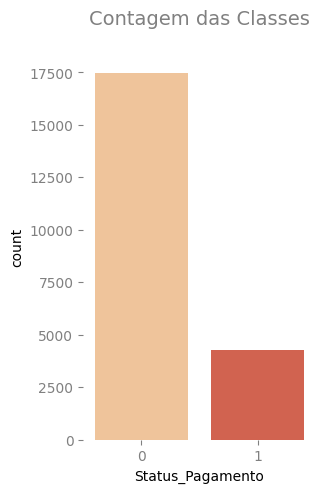

In [13]:
plt.figure(figsize=(3, 5))  # Ajuste o tamanho horizontal para acomodar todos os gráficos em uma linha

sns.countplot(x='Status_Pagamento', data=df_processing, palette="OrRd")

# Remover borda ao redor do gráfico
plt.box(False)

# Ajustando o título com uma quebra de linha
plt.title("Contagem das Classes\n", color='grey', fontsize=14)

# Ajustando a cor das bordas esquerda e inferior para cinza
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')

# Ajustar a cor dos ticks para cinza
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')

# Exibe o gráfico
plt.show()

Podemos notar que a variável "0", que condiz à pessoas adimplentes, possui muitas amostras a mais. Isso prejudica o modelo, pois aprenderá muito mais sobre identificar a variável 0 do que a 1.
- Para isso, utilizarei o SMOTE, a fim de criar dados sintéticos com base nos originais

In [14]:
# Separa X e y
target = df_processing['Status_Pagamento']
features = df_processing.drop(columns=['Status_Pagamento'])

seed = 100

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X, y = smote_bal.fit_resample(features, target)

In [15]:
X.shape

(34942, 17)

In [16]:
y.shape

(34942,)

In [17]:
y.value_counts()

Status_Pagamento
0    17471
1    17471
Name: count, dtype: int64

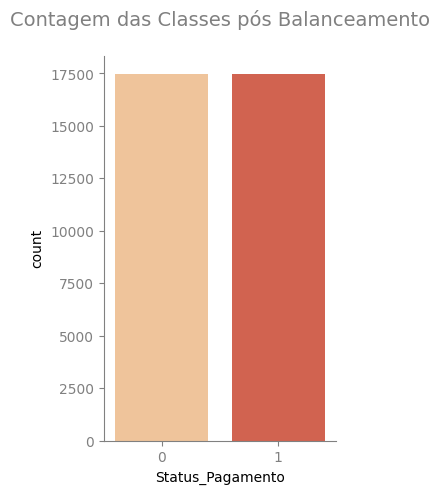

In [20]:
plt.figure(figsize=(3, 5))  # Ajuste o tamanho horizontal para acomodar todos os gráficos em uma linha
sns.countplot(x=y, palette='OrRd')

# Configurações estéticas
# plt.title('Distribuição de Valores da Variável y', fontsize=16)
# plt.xlabel('Valores de y', fontsize=14)
# plt.ylabel('Contagem', fontsize=14)
# plt.xticks(fontsize=12, color='grey')
# plt.yticks(fontsize=12, color='grey')

plt.title("Contagem das Classes pós Balanceamento\n", color='grey', fontsize=14)

# Ajustando a cor das bordas esquerda e inferior para cinza
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')

# Ajustar a cor dos ticks para cinza
plt.tick_params(axis='x', colors='grey')
plt.tick_params(axis='y', colors='grey')
# Remover as linhas de cima e direita do gráfico para deixá-lo mais limpo
sns.despine()

plt.show()

In [42]:
X.sample()

,Idade,Renda_Anual,Anos_no_Emprego,Grau_Emprestimo,Valor,Taxa_Juros,Comprometimento_Renda,Inadimplencia_Historica,Duracao_Historico_Credito,Tipo_Moradia_Hipoteca,Tipo_Moradia_Outro,Tipo_Moradia_Próprio,Motivo_Emprestimo_Educação,Motivo_Emprestimo_Empreendimento,Motivo_Emprestimo_Médico,Motivo_Emprestimo_Pessoal,Motivo_Emprestimo_Reformas Domésticas
24244,-0.829851,-0.71475,-0.423843,3,-0.71035,1.439799,-0.351445,1,-0.288521,0,0,0,0,0,0,0,0


In [43]:
print(y)

0        0
1        1
2        1
3        1
4        0
        ..
34937    1
34938    1
34939    1
34940    1
34941    1
Name: Status_Pagamento, Length: 34942, dtype: int32


<font color = "red">Importância de Cada Variável com Random Forest

In [44]:
clf_importancia_var = RandomForestClassifier(n_estimators = 10, max_depth=7)

In [45]:
clf_importancia_var =  clf_importancia_var.fit(X, y)

In [46]:
clf_importancia_var.score(X, y)

0.8433403926506783

In [47]:
importancia_Var = clf_importancia_var.feature_importances_

In [48]:
importancia_Var

array([1.03652747e-02, 1.46689063e-01, 3.30312774e-02, 2.07776809e-01,
       3.78676615e-02, 1.56403926e-01, 2.34640941e-01, 1.59971176e-02,
       1.42218322e-02, 4.99577391e-02, 1.67872437e-04, 3.99507683e-02,
       1.61563043e-02, 2.06603318e-02, 3.40816625e-03, 5.16083334e-03,
       7.54408118e-03])

In [49]:
X.columns

Index(['Idade', 'Renda_Anual', 'Anos_no_Emprego', 'Grau_Emprestimo', 'Valor',
       'Taxa_Juros', 'Comprometimento_Renda', 'Inadimplencia_Historica',
       'Duracao_Historico_Credito', 'Tipo_Moradia_Hipoteca',
       'Tipo_Moradia_Outro', 'Tipo_Moradia_Próprio',
       'Motivo_Emprestimo_Educação', 'Motivo_Emprestimo_Empreendimento',
       'Motivo_Emprestimo_Médico', 'Motivo_Emprestimo_Pessoal',
       'Motivo_Emprestimo_Reformas Domésticas'],
      dtype='object')

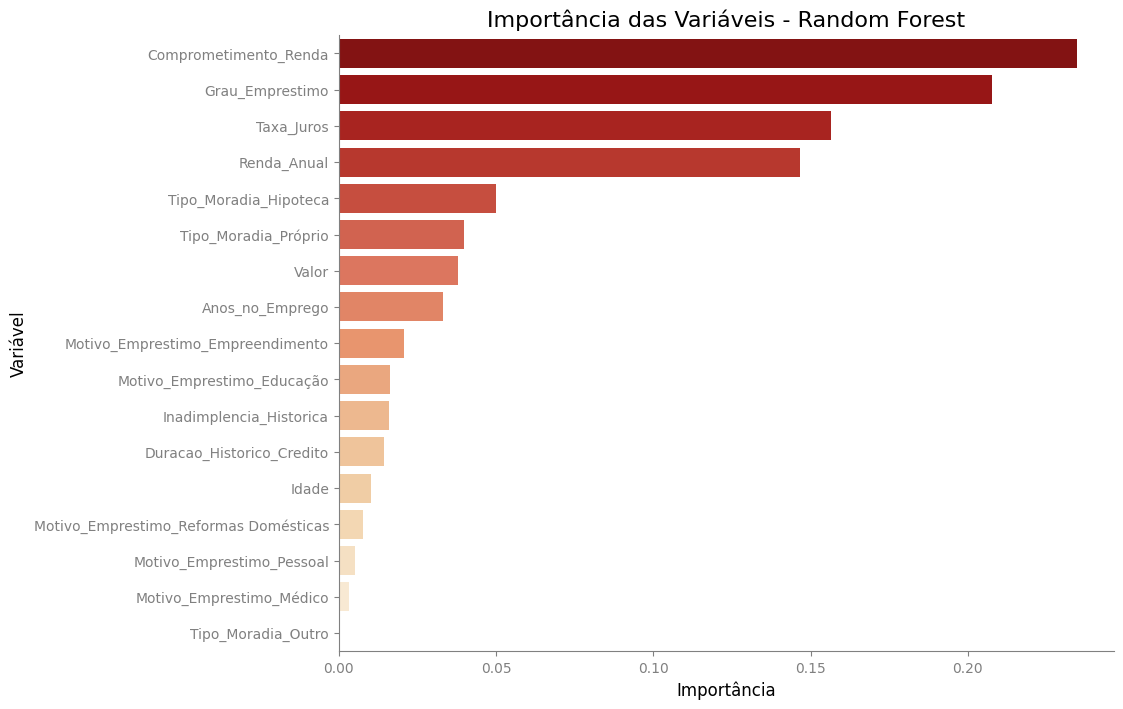

In [54]:
# Plotar a importância das variáveis
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variavel', data=df_importancia, palette='OrRd_r')  # Usando a paleta invertida
plt.title('Importância das Variáveis - Random Forest', fontsize=16)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Variável', fontsize=12)

# Remover bordas superior e direita
sns.despine()

# Ajustar a cor das bordas esquerda e inferior para cinza
plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')

# Ajustar a cor dos ticks
plt.tick_params(axis='x', colors='grey')  # Ticks do eixo x
plt.tick_params(axis='y', colors='grey')  # Ticks do eixo y

# Exibe o gráfico
plt.show()

### <font color = "blue"> Conclusões:

- Variável idade já não se mostrava relevante na corr (multicolinearidade com Duração Histórico), agora ainda menos. Vou excluir as duas.
- As demais irei manter, mesmo que vaolor e comprometimento renda possuam 0.64 de correlação, são variáveis relevantes para o problema de negócio

In [145]:
X = X.drop(columns=['Idade', 'Duracao_Historico_Credito'])


<font color = "red">Salvando variáveis para modelagem preditiva

In [148]:
X.to_csv('../data/X_pre_processado_5.csv', sep =',', index = False, encoding = 'utf-8')
y.to_csv('../data/y_pre_processado_5.csv', sep =',', index = False, encoding = 'utf-8')